## Description
This is the cross correlation calculation result. The result should show below in the first graph (ignore the first 2). You might need to invoke the cell below here to see the graph.

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Peaks: ['3.0e+10', '4.0e+08', '5.4e+08', '2.7e+08']
Time 0.016757369614512473
Speed of Sound 346.45
Distance 2.902795351473923
------
Peaks: ['3.1e+10', '4.9e+08', '2.3e+08']
Time 0.022607709750566893
Speed of Sound 346.45
Distance 3.91622052154195
------
Peaks: ['3.0e+10', '5.7e+08']
Time 0.022403628117913833
Speed of Sound 346.45
Distance 3.8808684807256237
------
Peaks: ['3.0e+10', '6.5e+08']
Time 0.022290249433106576
Speed of Sound 346.45
Distance 3.8612284580498866
------
Peaks: ['3.0e+10', '8.4e+08']
Time 0.02140589569160998
Speed of Sound 346.45
Distance 3.7080362811791385
------
Peaks: ['3.0e+10', '7.6e+08']
Time 0.022448979591836733
Speed of Sound 346.45
Distance 3.888724489795918
------
Peaks: ['3.0e+10', '9.1e+08']
Time 0.02197278911564626
Speed of Sound 346.45
Distance 3.806236394557823
------
Peaks: ['3.1e+10', '7.6e+08']
Time 0.022675736961451247
Speed of Sound 346.45
Distance 3.9280045351473922
------
Peaks: ['3.1e+10', '6.6e+08', '4.0e+08', '3.0e+08']
Time 0.01748299319

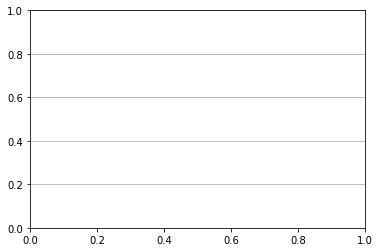

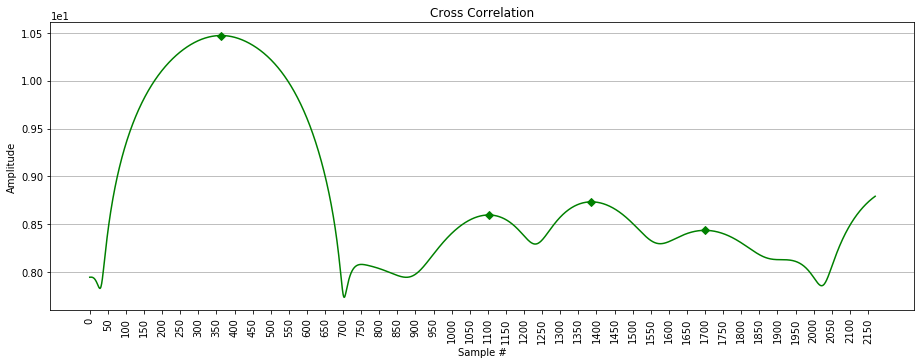

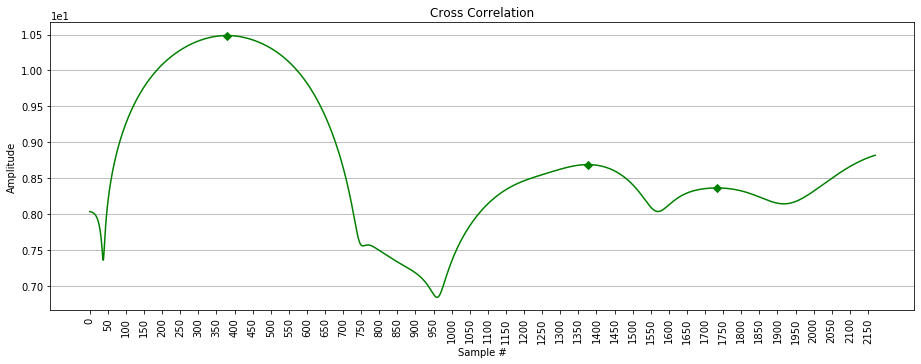

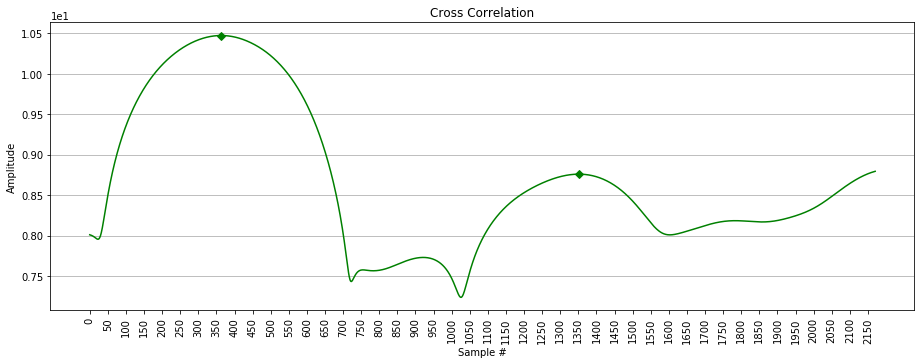

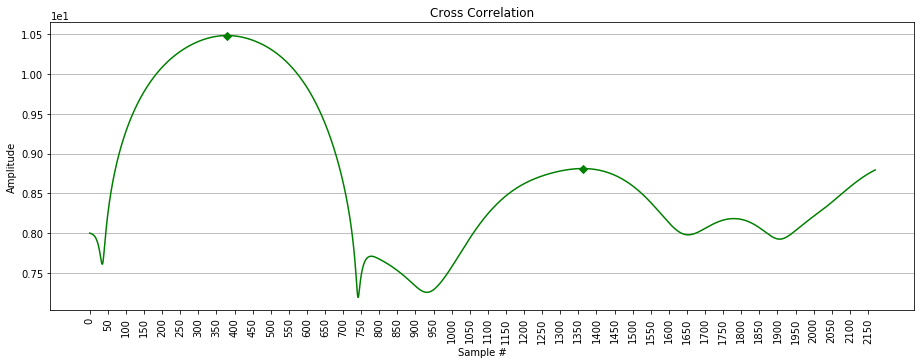

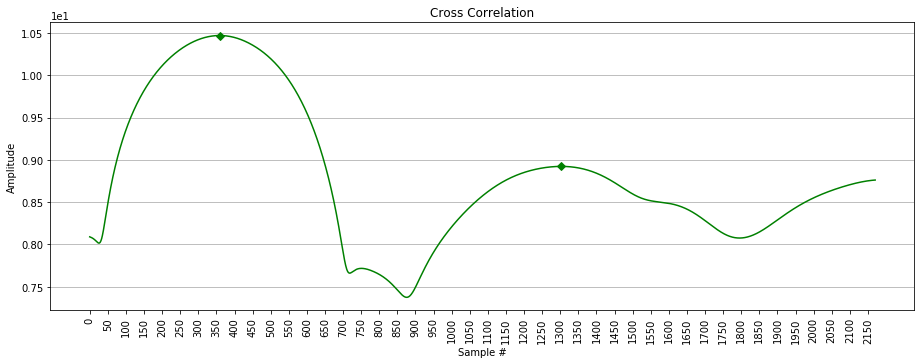

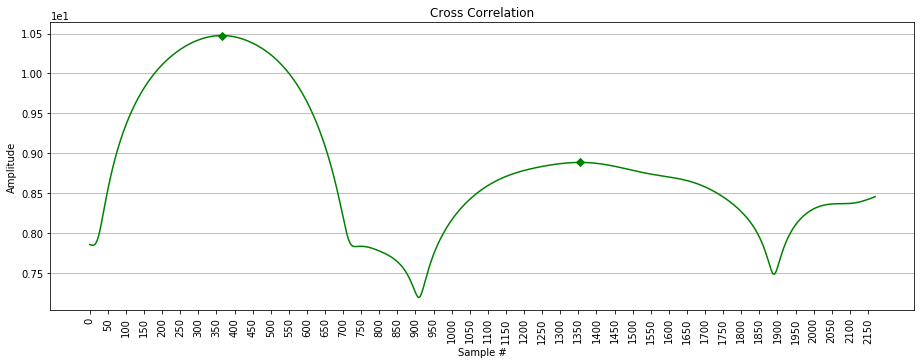

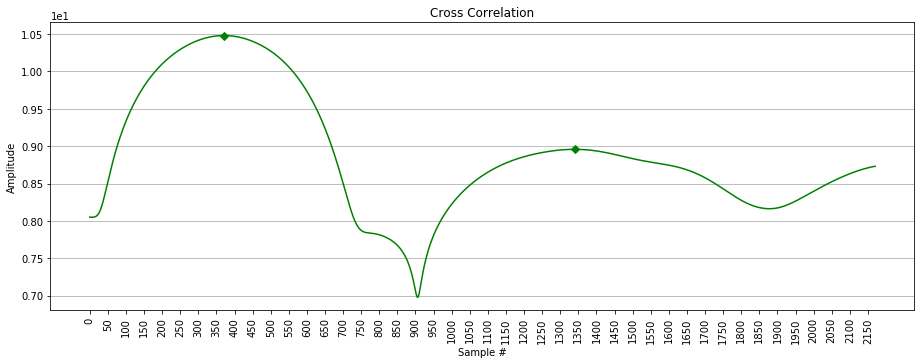

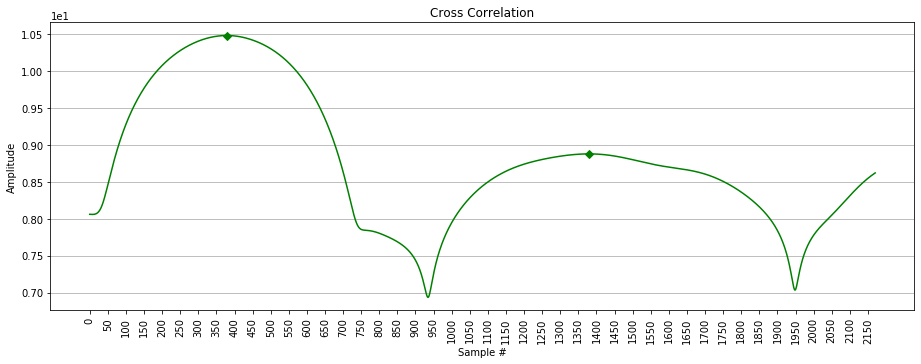

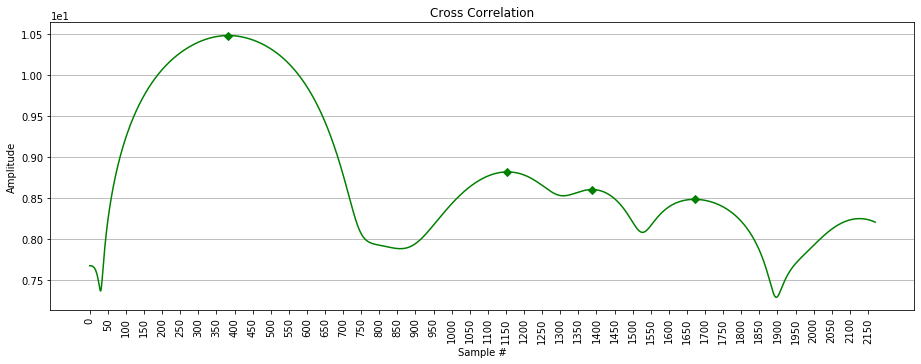

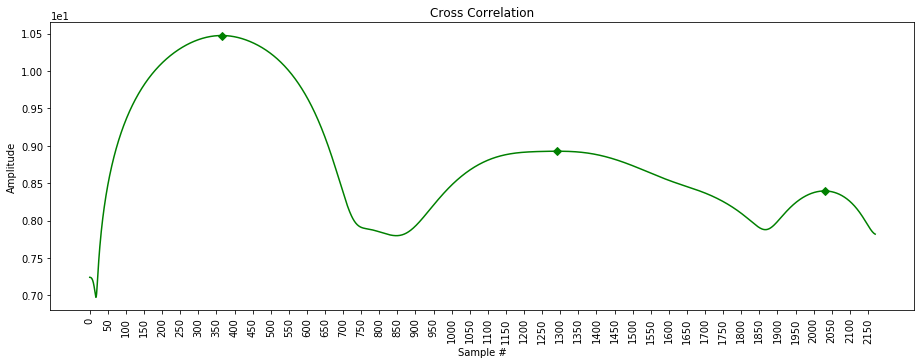

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt
import analysis as an
import cross_correlation_analyzer as cca
import numpy as np
from scipy import signal

threshold = 2e8
distance=0

distances = []
print_format = "Time {0}\nSpeed of Sound {1}\nDistance {2}"

for sample_number in range(1, 11):
    cc = cca.get_cc(sample_number)
    time_delta, speed_of_sound, half_distance, peaks = \
        cca.get_distances(cc, threshold)
    if half_distance:
        distances.append(half_distance)
    print("Peaks: {}".format(["{0:.1e}".format(cc[p]) for p in peaks]))
    print(print_format.format(time_delta, speed_of_sound, half_distance))
    logcc = [np.log10(c) for c in cc]
    an.get_graph_figure(logcc, 'Cross Correlation', markers=peaks)
    print("------")

print("Avg distance: {}".format(np.mean(distances)))